# GROVER lösen SODUKU Problem

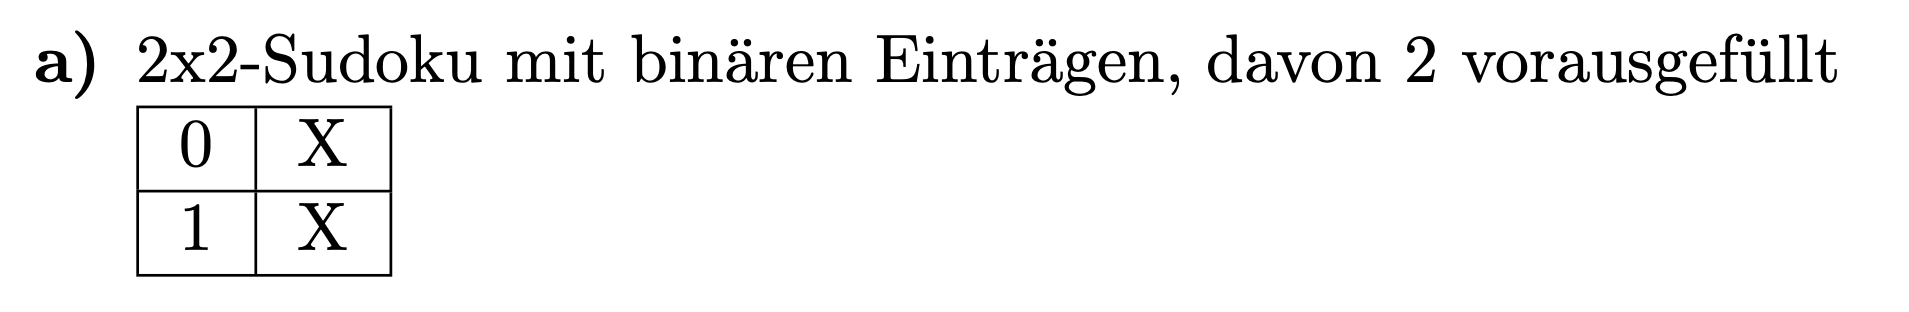

In [20]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister,\
    ClassicalRegister,transpile, Aer, IBMQ,execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-10-17 13:47:36,328: Credentials are already in use. The existing account in the session will be replaced.


In [21]:
def reflection(qc,x):
    '''Performs reflection around state |0>: adds a negative phase only to state |0>'''
    qc.x(x)
    qc.h(x[-1]) #apply hadamard to last qubit
    qc.mcx(x[:-1],x[-1]) #apply multi control x gate
    qc.h(x[-1])
    qc.x(x)
def diffuser(qc,x):
    '''Transforms superposition state |s> -> |0>, reflects about |0>
    and transforms back to |s> again.'''
    qc.h(x)
    reflection(qc,x)
    qc.h(x)

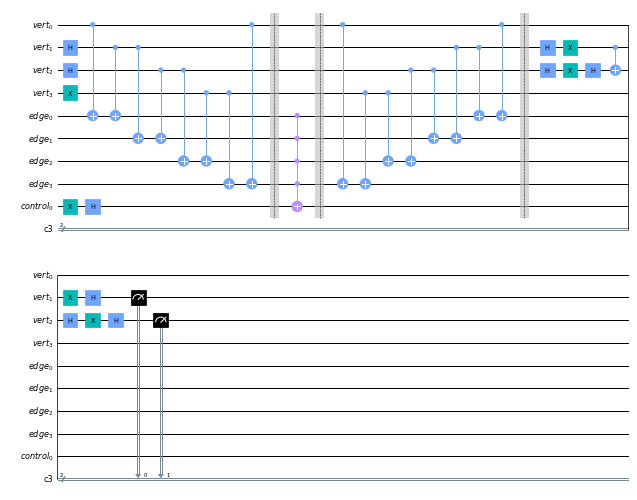

In [22]:
vert = QuantumRegister(4, name ='vert')
edg = QuantumRegister(4, name ='edge')
contr = QuantumRegister(1, name ='control')
cr = ClassicalRegister(2)
qc = QuantumCircuit(vert, edg, contr, cr)

#color coding: 0-> yellow, 1-> blue
#vertices 0 (yellow) and 1 (blue) are known
qc.x(vert[3])
#the rest are unknown: apply H
qc.h(vert[1])
qc.h(vert[2])
#set control qubit in state |->
qc.x(contr)
qc.h(contr)
#apply U_f
#encode edges
#0-1
qc.cx(vert[0],edg[0])
qc.cx(vert[1],edg[0])
#1-2
qc.cx(vert[1],edg[1])
qc.cx(vert[2],edg[1])
#2-3
qc.cx(vert[2],edg[2])
qc.cx(vert[3],edg[2])
#3-0
qc.cx(vert[3],edg[3])
qc.cx(vert[0],edg[3])
#add negative amplitude to the state with all ones (all edges connecting nodes with different colours)
qc.barrier()
qc.mcx(edg,contr)
qc.barrier()
#reverse edge encoding
qc.cx(vert[0],edg[3])
qc.cx(vert[3],edg[3])
qc.cx(vert[3],edg[2])
qc.cx(vert[2],edg[2])
qc.cx(vert[2],edg[1])
qc.cx(vert[1],edg[1])
qc.cx(vert[1],edg[0])
qc.cx(vert[0],edg[0])
qc.barrier()
#diffuser
diffuser(qc,vert[1:3])
qc.measure(vert[1:3],cr)
qc.draw('mpl', scale=0.5)

### Kosten:

In [28]:
pass_ = Unroller(['u3', 'cx'])
print('pass', pass_)
pm = PassManager(pass_)
print('pm', pm)
new_circuit = pm.run(qc)

ops = new_circuit.count_ops()
print(ops)
cost = ops['u3'] + 10 * ops['cx'] 
print("Cost: " + str(cost))

pass <qiskit.transpiler.passes.basis.unroller.Unroller object at 0x7fb008077130>
pm <qiskit.transpiler.passmanager.PassManager object at 0x7fb008077220>
OrderedDict([('u3', 84), ('cx', 53), ('barrier', 3), ('measure', 2)])
Cost: 614


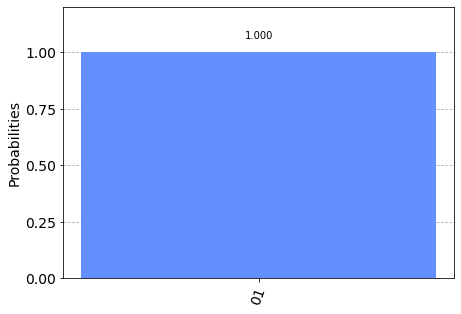

In [24]:
#run on simulator
backend = Aer.get_backend('qasm_simulator') 
result = execute(qc, backend).result()

plot_histogram(result.get_counts())

In [29]:
from qiskit import QuantumCircuit, Aer, assemble, IBMQ, transpile
for kk in range(4):
    trans_qc = transpile(qc, basis_gates=['cx', 'u3'], optimization_level=kk)
    
    #display(trans_qc.draw())
    print('Optimization Level {}'.format(kk))
    print('Depth:', trans_qc.depth())
    print('Gate counts:', trans_qc.count_ops())

Optimization Level 0
Depth: 105
Gate counts: OrderedDict([('u3', 84), ('cx', 53), ('barrier', 3), ('measure', 2)])
Optimization Level 1
Depth: 85
Gate counts: OrderedDict([('cx', 53), ('u3', 49), ('barrier', 3), ('measure', 2)])
Optimization Level 2
Depth: 85
Gate counts: OrderedDict([('cx', 53), ('u3', 49), ('barrier', 3), ('measure', 2)])
Optimization Level 3
Depth: 85
Gate counts: OrderedDict([('cx', 53), ('u3', 49), ('barrier', 3), ('measure', 2)])


In [31]:
pass_ = Unroller(['u3', 'cx'])
print('pass', pass_)
pm = PassManager(pass_)
print('pm', pm)
new_circuit = pm.run(trans_qc)

ops = new_circuit.count_ops()
print(ops)
cost = ops['u3'] + 10 * ops['cx'] 
print("Cost: " + str(cost))

pass <qiskit.transpiler.passes.basis.unroller.Unroller object at 0x7fb02c10ca30>
pm <qiskit.transpiler.passmanager.PassManager object at 0x7fb02c10c100>
OrderedDict([('cx', 53), ('u3', 49), ('barrier', 3), ('measure', 2)])
Cost: 579
